In [1]:
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

2.19.0


In [2]:
columns = [
    'Boarded', 'actual_date', 'Destination Airport_encoded', 'Airline_encoded',
    'Day_of_Week', 'Month', 'Day_of_Month', 'day_sin',  'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 'route_mean', 'route_median', 'route_std',
     'max_seats'
]

df = pd.read_csv('Datasets/SRQ_flights.csv', usecols=columns)
df['actual_date'] = pd.to_datetime(df['actual_date']).dt.tz_localize(None)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Boarded                      14016 non-null  int64         
 1   Day_of_Week                  14016 non-null  int64         
 2   Month                        14016 non-null  int64         
 3   Day_of_Month                 14016 non-null  int64         
 4   Destination Airport_encoded  14016 non-null  int64         
 5   Airline_encoded              14016 non-null  int64         
 6   day_sin                      14016 non-null  float64       
 7   day_cos                      14016 non-null  float64       
 8   month_sin                    14016 non-null  float64       
 9   month_cos                    14016 non-null  float64       
 10  dow_sin                      14016 non-null  float64       
 11  dow_cos                      14016 non-nu

In [3]:
#Extract time of day in seconds
df['seconds_in_day'] = (
    df['actual_date'].dt.hour * 3600 +
    df['actual_date'].dt.minute * 60 +
    df['actual_date'].dt.second
)

# Normalize to [0, 2π]
seconds_in_day_total = 24 * 60 * 60  # 86400
df['time_angle'] = 2 * np.pi * df['seconds_in_day'] / seconds_in_day_total

# Compute sin and cos
df['time_sin'] = np.sin(df['time_angle'])
df['time_cos'] = np.cos(df['time_angle'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Boarded                      14016 non-null  int64         
 1   Day_of_Week                  14016 non-null  int64         
 2   Month                        14016 non-null  int64         
 3   Day_of_Month                 14016 non-null  int64         
 4   Destination Airport_encoded  14016 non-null  int64         
 5   Airline_encoded              14016 non-null  int64         
 6   day_sin                      14016 non-null  float64       
 7   day_cos                      14016 non-null  float64       
 8   month_sin                    14016 non-null  float64       
 9   month_cos                    14016 non-null  float64       
 10  dow_sin                      14016 non-null  float64       
 11  dow_cos                      14016 non-nu

In [4]:
feature_columns = [  'Destination Airport_encoded', 'Airline_encoded',
    #'Day_of_Week', 'Month', 'Day_of_Month', 
    'day_sin',  'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 
    'route_mean', 'route_median', 'route_std', 'time_sin', 'time_cos', 'max_seats']

In [5]:
X = df[feature_columns]
y = df['Boarded']  # or whatever your target column is
dates = df['actual_date']


split_index = int(len(df) * 0.8)

# Split data chronologically
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
#X_test = X_train

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
#y_test = y_train

dates_train = dates.iloc[:split_index]
dates_test = dates.iloc[split_index:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 11212
Testing set size: 2804
Training target range: 10 to 249
Testing target range: 10 to 238


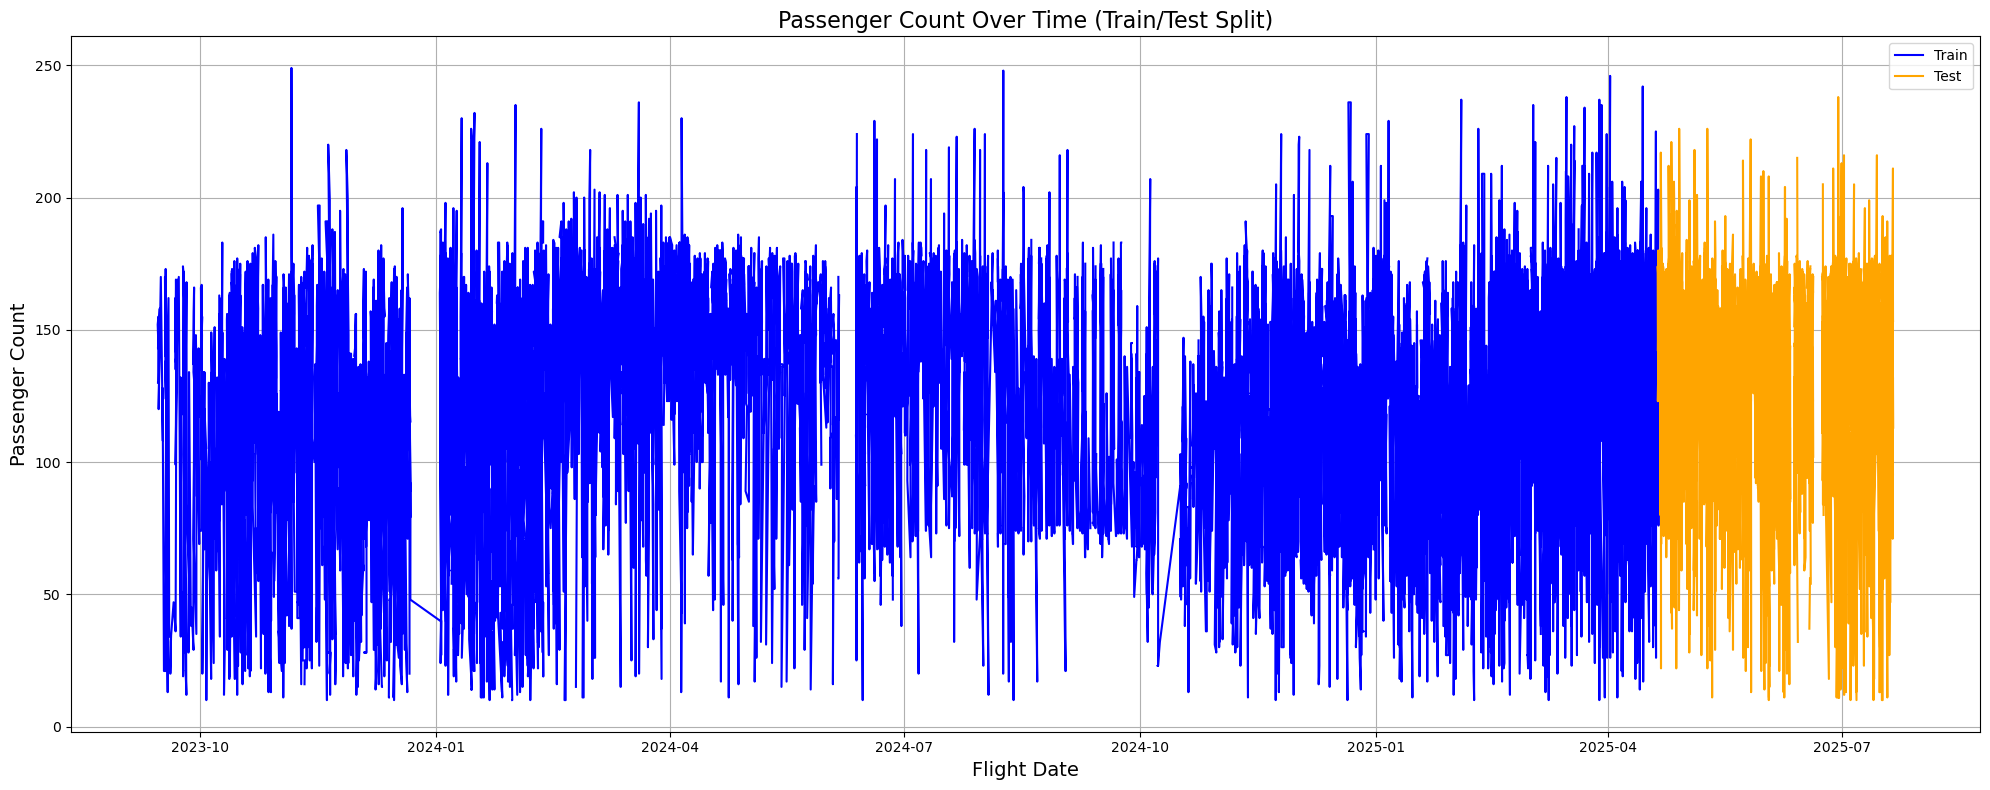

In [6]:
# Get the split index (number of training samples)
split_index = len(y_train)

# Extract date and passenger count
df_timestamps = df['actual_date']
passenger_counts = df['Boarded']

# Plot
plt.figure(figsize=(20, 8))

plt.plot(df_timestamps[:split_index], passenger_counts[:split_index], label='Train', color='blue')
plt.plot(df_timestamps[split_index:], passenger_counts[split_index:], label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)', fontsize=16)
plt.xlabel('Flight Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler
 
# Define scheduler function
def scheduler(epoch, lr):
    if epoch%10 != 0:
        return lr
    else:
        return lr * 0.925  # decay by 10%
 
lr_callback = LearningRateScheduler(scheduler)

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(14,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),    
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse']
             )

model.summary()

C:\Users\KamarioSinclair\.conda\envs\pax-prediction\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1024)           │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,452,481 (24.61 MB)

 Trainable params: 6,452,481 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# For validation during training, use chronological split within training data
# Take last 20% of training data as validation set
val_split_index = int(len(X_train) * 0.8)

X_train_final = X_train[:val_split_index]
X_val = X_train[val_split_index:]
y_train_final = y_train.iloc[:val_split_index]
y_val = y_train.iloc[val_split_index:]

print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

# Check for infinities
print("Infs in X_val:", np.isinf(X_val).sum())
print("Infs in y_val:", np.isinf(y_val).sum())

NaNs in X_val: Destination Airport_encoded     0
Airline_encoded                 0
day_sin                         0
month_sin                       0
dow_sin                         0
day_cos                         0
month_cos                       0
dow_cos                         0
route_mean                      0
route_median                    0
route_std                       4
time_sin                       10
time_cos                       10
max_seats                       0
dtype: int64
NaNs in y_val: 0
Infs in X_val: Destination Airport_encoded    0
Airline_encoded                0
day_sin                        0
month_sin                      0
dow_sin                        0
day_cos                        0
month_cos                      0
dow_cos                        0
route_mean                     0
route_median                   0
route_std                      0
time_sin                       0
time_cos                       0
max_seats                      0
dt

In [15]:
history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=128,
                    validation_data=(X_val, y_val),  # or use x_test/y_test for validation if you prefer
                    verbose=1,
                    callbacks=[lr_callback])

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4477.6602 - mae: 52.4593 - mse: 4477.6602 - val_loss: 1952.0480 - val_mae: 36.8137 - val_mse: 1952.0480 - learning_rate: 9.2500e-04
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2065.6038 - mae: 37.7690 - mse: 2065.6038 - val_loss: 1895.9722 - val_mae: 36.1292 - val_mse: 1895.9722 - learning_rate: 9.2500e-04
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2014.6940 - mae: 37.3705 - mse: 2014.6940 - val_loss: 1949.8386 - val_mae: 36.7874 - val_mse: 1949.8386 - learning_rate: 9.2500e-04
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2027.9790 - mae: 37.4638 - mse: 2027.9790 - val_loss: 1719.8600 - val_mae: 33.6322 - val_mse: 1719.8600 - learning_rate: 9.2500e-04
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 2022.2087 - mae: 37.4126 - mse: 2022.2087 - val_loss: 1772.1245 - val_mae: 33.6673 - val_mse: 1772.1245 - learning_rate: 9.2500e-04
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4

In [16]:
output = model.evaluate(X_test, y_test, verbose=1)
print(output)

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1474.5464 - mae: 30.4999 - mse: 1474.5464
[1474.54638671875, 30.499916076660156, 1474.54638671875]


In [20]:
y_pred = model.predict(X_test)
y_true = y_test

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(array([20198.5, 20199. , 20199.5, 20200. , 20200.5, 20201. , 20201.5,
        20202. , 20202.5]),
 [Text(20198.5, 0, '04-20 12'),
  Text(20199.0, 0, '04-21 00'),
  Text(20199.5, 0, '04-21 12'),
  Text(20200.0, 0, '04-22 00'),
  Text(20200.5, 0, '04-22 12'),
  Text(20201.0, 0, '04-23 00'),
  Text(20201.5, 0, '04-23 12'),
  Text(20202.0, 0, '04-24 00'),
  Text(20202.5, 0, '04-24 12')])

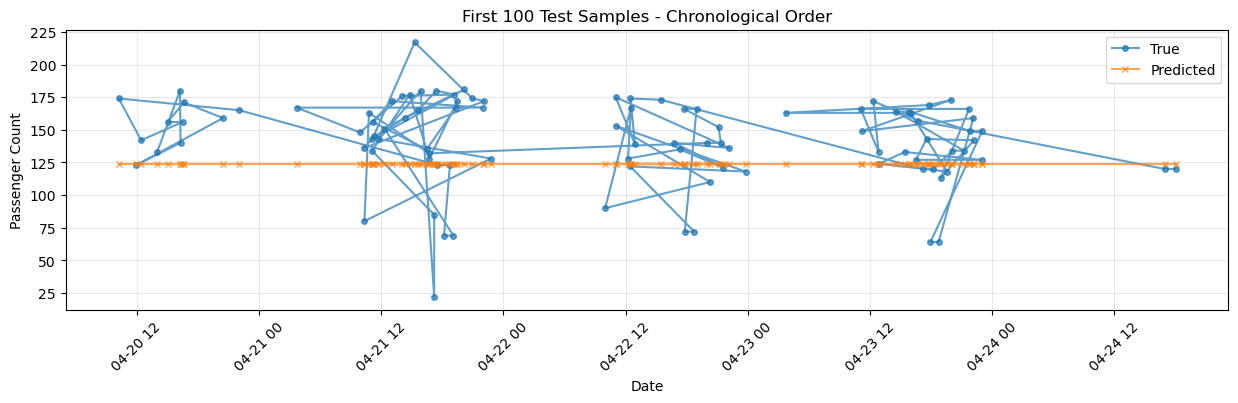

In [21]:
# Plot predictions vs actual - now dates align correctly
plt.figure(figsize=(15, 8))

# Plot first 100 test samples
n_samples = min(100, len(y_test))
dates_plot = dates_test.iloc[:n_samples]
y_true_plot = y_true[:n_samples]
y_pred_plot = y_pred[:n_samples]

plt.subplot(2, 1, 1)
plt.plot(dates_plot, y_true_plot, label='True', marker='o', alpha=0.7, markersize=4)
plt.plot(dates_plot, y_pred_plot, label='Predicted', marker='x', alpha=0.7, markersize=4)
plt.title('First 100 Test Samples - Chronological Order')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
